# Models with full df
## Create df with old and new scrapes
Read in the dataframnes and improve the model by making an interaction column that combines the title and posts to make a more word heavy column and run a model with and without it.

In [2]:
import pandas as pd

In [3]:
#read them in, I'm reading in these that may be the same, I am being safe because I had to copy and paste after 
#a computer shutdown.
o =pd.read_csv('../data/dfs/clean_new_csv.csv')
n =pd.read_csv('../data/dfs/clean2_new_csv')
#old = pd.read_csv('./clean')
old =pd.read_csv('../data/dfs/clean2_old_csv')   #cleaned scrapes from sunday
new =pd.read_csv('../data/dfs/clean2_new_csv')   #cleaned scrapes from mond

In [4]:
#make a full df
data = pd.merge(old, new, how ='outer')
data.shape

(3527, 4)

In [5]:
#fill nulls with empty string.
data.isnull().sum()

Unnamed: 0       0
post          3301
title            0
subreddit        0
dtype: int64

In [6]:
data.fillna('', inplace=True)

In [7]:
data.isna().sum()

Unnamed: 0    0
post          0
title         0
subreddit     0
dtype: int64

In [8]:
data.head(2)

,Unnamed: 0,post,title,subreddit
0,0,,Brexcellent!,1
1,1,,Graffiti - LIDE - Yellow Letters,1


In [9]:
#combine useful words to one column.
data['words'] = data['title'] + data['post']
data.head(2)

,Unnamed: 0,post,title,subreddit,words
0,0,,Brexcellent!,1,Brexcellent!
1,1,,Graffiti - LIDE - Yellow Letters,1,Graffiti - LIDE - Yellow Letters


In [10]:
#save to csv
data.to_csv('../data/dfs/full_df_csv')

In [97]:
#data[['words']].head(2)

# Model
### Goal, make models of tfidf and mnb of full df['words'] with best params from notebook 3
One model with art as the target and the same model with hip hop as the target.
I have the baseline percentages here, close to 50/50, stratify anyway.

Remember, 1 is Street Art, and 0 is Hip Hop Heads.

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [12]:
#Okay, now I have options.  I'll model on the word column first and see if the scores are better than the
#pipeline from the previous notebook.
value_counts =data.subreddit.value_counts(normalize=True)
value_counts

1    0.568472
0    0.431528
Name: subreddit, dtype: float64

In [13]:
#split both and use words, then I'll have title and post separa... never mind.
X =data['words']
y =data['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

In [14]:
# coming back to remove more stop words
from sklearn.feature_extraction import stop_words

wordlist =list(stop_words.ENGLISH_STOP_WORDS)
wordlist += ['https', 'www', 'x200b', 've', 'll', 'jpg', 'gt', '20', '18', 'com', 'st']

In [15]:
#wordlist

In [16]:
pipe =Pipeline([
    ('tif', TfidfVectorizer(stop_words= wordlist, max_features=1000)),
    ('mnb', MultinomialNB())
])
#gridsearch
params ={
    'tif__max_df': [.94, .96],
    'tif__min_df': [2, 5, 10],
    'tif__ngram_range': [(1, 1), (1,3)]
}

In [17]:
gs =GridSearchCV(estimator =pipe, param_grid=params)
# Fit model
gs.fit(X_train, y_train)

/Users/alannabesaw/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tif', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tif__max_df': [0.94, 0.96], 'tif__min_df': [2, 5, 10], 'tif__ngram_range': [(1, 1), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [101]:
###################
#tif =TfidfVectorizer(stop_words =wordlist, max_features =1000)

In [102]:
###################
#tif to df so I can see the words
#X_train_tif =pd.DataFrame(tif.fit_transform(X_train).toarray(),
#                                columns=tif.get_feature_names())

In [126]:
###################
#X_train_tif.head(2)

In [127]:
gs.best_estimator_

Pipeline(memory=None,
     steps=[('tif', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.94, max_features=1000, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...rue,
        vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [18]:
#art word indicators
#most popular words in the post for both subreddits.

#poptif = X_train_tif.sum(axis=0)
#poptif.sort_values(ascending = False).head(50)

In [19]:
#hip hop word indicators

#poptif.sort_values(ascending = False).tail(50)

In [128]:
#coefs from gs mnb/tif art as the target
mnb_art_coefs = pd.DataFrame(gs.best_estimator_.named_steps.mnb.coef_,
                            columns = gs.best_estimator_.named_steps.tif.get_feature_names()).T

In [129]:
mnb_art_coefs.columns =['Art Coefs']

In [155]:
#strength of predictors or NOT
artplot =mnb_art_coefs.sort_values('Art Coefs', ascending =False)[:30]#[-30:]
artplot

,Art Coefs
art,-3.457036
street,-3.490117
mural,-4.359408
graffiti,-4.458887
london,-4.951367
uk,-5.094248
spain,-5.095996
artist,-5.130958
new,-5.132586
amp,-5.158147


# Make H-hop the target and see if there is a difference with all ['words']

In [19]:
#read back in the df and remap the target to make hhop the 1 and art the 0
hhop =pd.read_csv('../data/dfs/full_df_csv')

In [20]:
hhop.shape

(3527, 6)

In [21]:
hhop.tail(2)

,Unnamed: 0,Unnamed: 0.1,post,title,subreddit,words
3525,3525,1788,NaN,OliveGreen - Wasabi (Official Music Video),0,OliveGreen - Wasabi (Official Music Video)
3526,3526,1789,NaN,Nitembezee - Gabiro Mtu Necessary Ft. Kidis,0,Nitembezee - Gabiro Mtu Necessary Ft. Kidis


In [22]:
hhop.head(1)

,Unnamed: 0,Unnamed: 0.1,post,title,subreddit,words
0,0,0,NaN,Brexcellent!,1,Brexcellent!


In [23]:
#map 1 for art and 0 for music
hhop['subreddit'] =hhop['subreddit'].map({1: 0, 0: 1})
hhop.head(2)

,Unnamed: 0,Unnamed: 0.1,post,title,subreddit,words
0,0,0,NaN,Brexcellent!,0,Brexcellent!
1,1,1,NaN,Graffiti - LIDE - Yellow Letters,0,Graffiti - LIDE - Yellow Letters


In [24]:
hhop.tail(2)

,Unnamed: 0,Unnamed: 0.1,post,title,subreddit,words
3525,3525,1788,NaN,OliveGreen - Wasabi (Official Music Video),1,OliveGreen - Wasabi (Official Music Video)
3526,3526,1789,NaN,Nitembezee - Gabiro Mtu Necessary Ft. Kidis,1,Nitembezee - Gabiro Mtu Necessary Ft. Kidis


In [25]:
#okay, hhop is now the target, so I'll run the model on this one.
hhop.subreddit.value_counts(normalize=True)

0    0.568472
1    0.431528
Name: subreddit, dtype: float64

In [26]:
#split both and use words, then I'll have title and post separa... never mind.
X =hhop['words']
y =hhop['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

In [27]:
hh_pipe =Pipeline([
    ('tif', TfidfVectorizer(stop_words=wordlist, max_features=1000)),
    ('mnb', MultinomialNB())
])
#gridsearch
params ={
    'tif__max_df': [.94, .96],
    'tif__min_df': [2, 5, 10],
    'tif__ngram_range': [(1, 1), (1,3)]
}

In [28]:
hh_gs =GridSearchCV(estimator =hh_pipe, param_grid=params)

# Fit your model
hh_gs.fit(X_train, y_train)

/Users/alannabesaw/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tif', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tif__max_df': [0.94, 0.96], 'tif__min_df': [2, 5, 10], 'tif__ngram_range': [(1, 1), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
hh_gs.best_estimator_

Pipeline(memory=None,
     steps=[('tif', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.94, max_features=1000, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...rue,
        vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [30]:
#coefs from gs mnb/tif art as the target
mnb_hh_coefs = pd.DataFrame(hh_gs.best_estimator_.named_steps.mnb.coef_,
                            columns = hh_gs.best_estimator_.named_steps.tif.get_feature_names()).T

In [31]:
mnb_hh_coefs.columns =['HipHop Coefs']

In [32]:
#strength of predictors or NOT
hhopplot =mnb_hh_coefs.sort_values('HipHop Coefs', ascending =False)[:30]#[-30:]
hhopplot

,HipHop Coefs
fresh,-3.096694
amp,-3.996716
ft,-4.059070
video,-4.096751
feat,-4.237828
lil,-4.455071
album,-4.582232
prod,-4.587742
official,-4.625011
music,-4.882610


The coefficient tables are similar, but not very different.

# Coefficient Plots

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

NameError: name 'artplot' is not defined

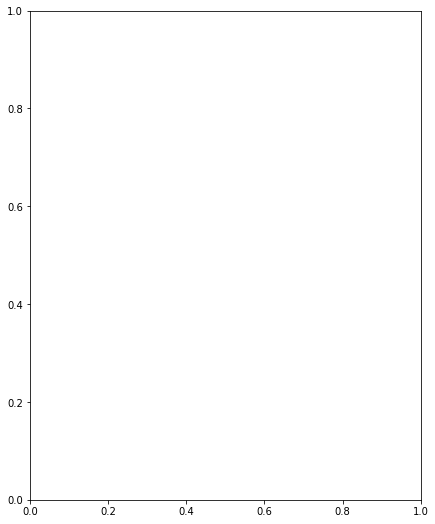

In [34]:
fig, ax = plt.subplots(figsize=(7,9))
sns.barplot(x=artplot["Art Coefs"], y=artplot.index, orient="h", color="white", edgecolor ='c')
ax.set_title("Art Coefficients, Multinomial NB and TFIDF");

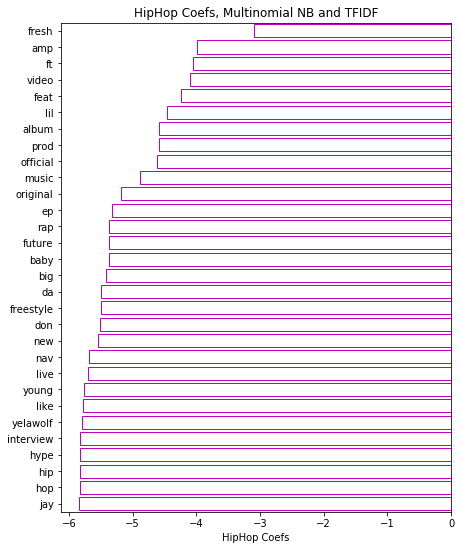

In [35]:
fig, ax = plt.subplots(figsize=(7,9))
sns.barplot(x=hhopplot["HipHop Coefs"], y=hhopplot.index, orient="h", color="white", edgecolor ='m')
ax.set_title("HipHop Coefs, Multinomial NB and TFIDF");

# interactive probability!
With the target 1 as hip hop as opposed to art.

In [36]:
hh_gs.predict_proba(['Colorless green ideas sleep furiously'])

array([[0.5103306, 0.4896694]])

In [37]:
#hip hop is 1
def grapher(sentence):
    return hh_gs.predict_proba([sentence])[0][0]

In [38]:
#xxxxx.plot(kind="bar", color="green")

In [39]:
grapher('ponies in the field whinny and neigh')

0.5686200378071834

In [40]:
str = ["Something about mountains"]
hh_gs.predict_proba(str)[0][0]

0.5686200378071834

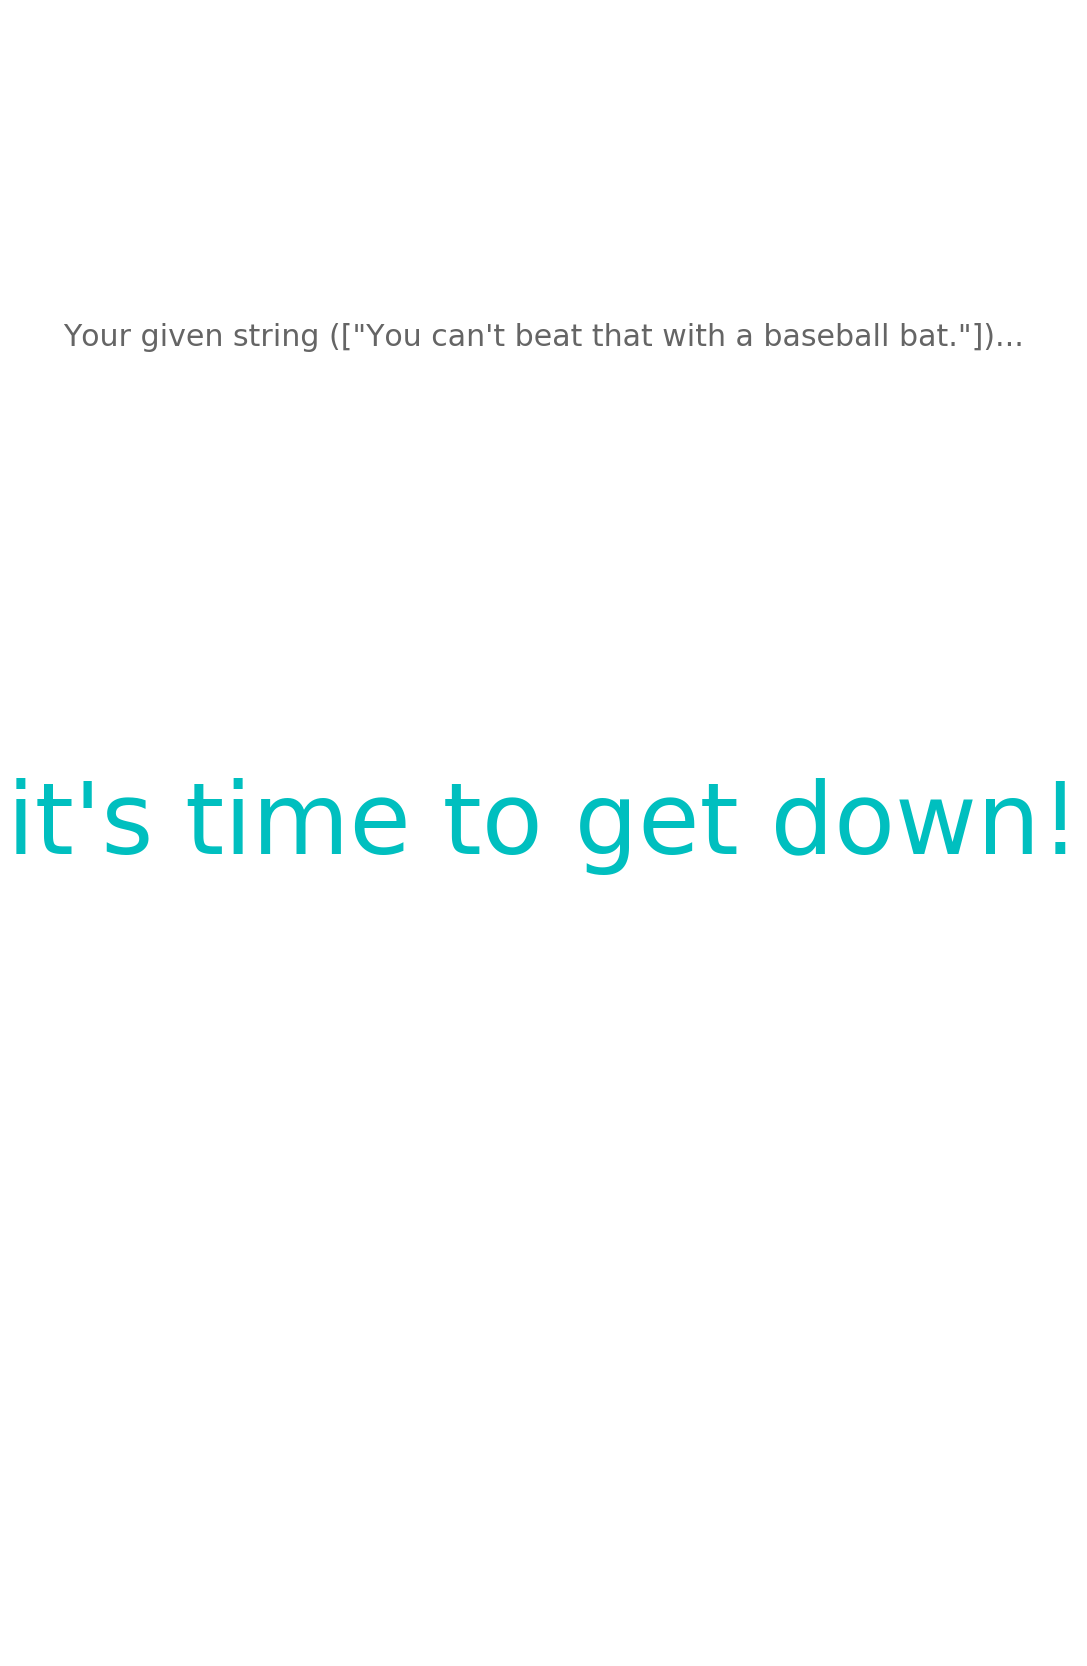

In [46]:
#Derek helped me with this formatting for my function, from his ames project.
str = ["You can't beat that with a baseball bat."]

# Code adapted from data viz lecture
plt.figure(figsize=(8, 30))

plt.text(x = 0.5,                       
         y = 0.8,                  
         s = f"Your given string ({str})...",
         ha = 'center',                     
         va = 'center',                    
         size = 30,
         alpha = 0.6)                     
          
if hh_gs.predict_proba(str)[0][0] >= 0.5:
    plt.text(x = 0.5,
             y = 0.5,
             s = f"is a masterpiece of street art!",
             ha = 'center',
             va = 'center',
             size = 100,
             alpha = 1,
             color ='g')
else: 
    plt.text(x = 0.5,
             y = 0.5,
             s = f"it's time to get down!",
             ha = 'center',
             va = 'center',
             size = 100,
             alpha = 1,
             color ='c')      
plt.axis('off');

In [161]:
grapher('''Yet our best trained, best educated, best equipped, best prepared troops refuse to fight. As a 
    matter of fact, it’s safe to say that they would rather switch than fight 1989 the number another summer 
    get down Sound of the funky drummer Music hitting your heart cause I know you got soul (Brothers and 
    sisters, hey) Listen if youre missing yall Swinging while Im singing Giving whatcha getting Knowing what 
    I know While the Black bands sweatin And the rhythm rhymes rollin Got to give us what we want (uh) Gotta 
    give us what we need (hey) Our freedom of speech is freedom or death We got to fight the powers that be 
    Lemme hear you say Fight the power (lemme hear you say) Fight the power Fight the power Fight the power
    Fight the power Fight the power''')

array([[0.50919507, 0.49080493]])

In [162]:
grapher('In and around the lake, mountains come out of the sky and they stand there')

array([[0.60334622, 0.39665378]])

In [163]:
grapher('eminem feat ep')

array([[0.01404857, 0.98595143]])

In [164]:
grapher('i took a long walk in the sunshine today')

array([[0.68535638, 0.31464362]])

In [166]:
grapher('graffiti street art')

array([[0.99855971, 0.00144029]])

# Evaluation
This is getting into interesting territory, it is outside the project but I think it is a simple and elegant idea that if I had known was possible from the beginning may have informed my subreddit choices to be something more universal.  However, it still is an actual example of topic modeling, so it's neat that here is a real interactive interpretation from data from one moment in time.  And not even that thoroughly cleaned, it still makes sense.  "this is what the topic may be", and in notebook 6 there is more with other subreddits that were the catalyst for this idea.